<a href="https://colab.research.google.com/github/SudeepSarkar/Computer-Vision-Course/blob/main/Lecture_9_2D_Geometric_Transformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Application: Panography

See 6.1.2 of the textbook

"One of the simplest (and most fun) applications of image alignment is a special form of image stitching called [panography](https://www.flickr.com/groups/panography/). In a panograph, images are translated and optionally rotated and scaled before being blended with simple averaging."

"This process mimics the photographic collages created by artist [David Hockney](https://www.hockney.com/works/photos/photographic-collages), although his compositions use an opaque overlay model, being created out of regular photographs."

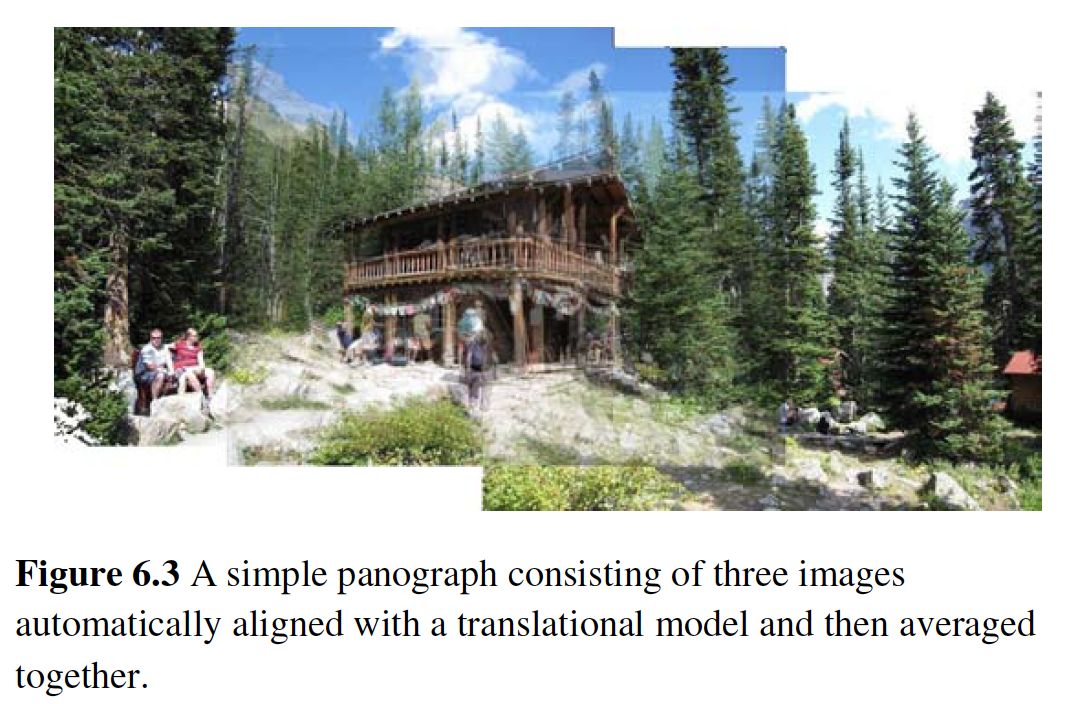

# 2D Geometric Transformation

See Fig 4.2 -- observe the geometric transformation between the planar surfaces between the two views. What is the mathematical relationship between them? How can we match image regions in a geometrically consistent manner? If you are tracking points on a plane, what model can we use as the underlying state model? What are some of the geometric models we can try? 

We will start with 2D transformations. But, first, we will study some mathematical preliminaries.

See Section 3.6 for additional reading materials on geometric transformations.


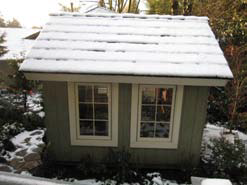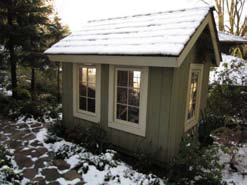

# Forward warping algorithm

**Problem**: The process of copying a pixel $f(x)$ to a location $x'$ in $g(x)$ is not well defined when $x'$ has a non-integer value.

> One solution: *splatting*: “distribute” the value among the four nearest neighbors in a weighted (bilinear) fashion, keeping track of the per-pixel weights and normalizing at the end.  However, this approach suffers from aliasing and a fair amount of blur (loss of high-resolution detail). Also, cracks and holes appear when magnifying an image.

**Solution**: Inverse warping.

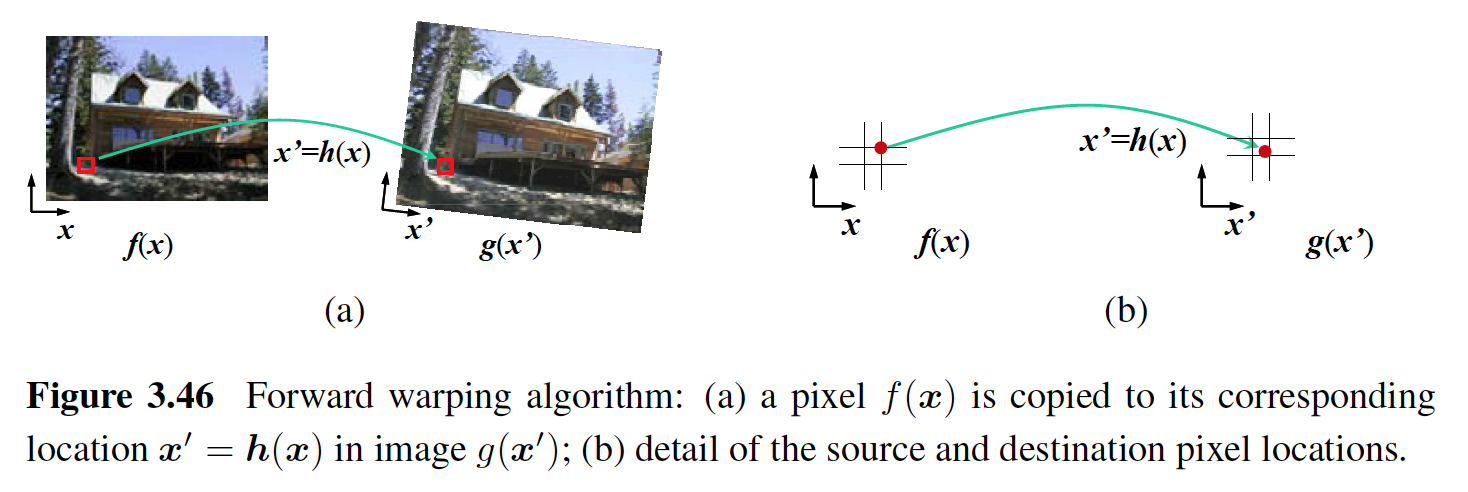

# Inverse mapping (preferred)

No holes!

It is preferable to formulate the problem of image warping as that of resampling
a source image $f(\mathbf{x})$ given a mapping $\mathbf{x} = h(\mathbf{x'})$ from destination pixels $\mathbf{x'}$ to source pixels $\mathbf{x}$.

To compute the value of $f(\mathbf{x})$ at a non-integer location $\mathbf{x}$, we can employ bilinear interpolation among the neighboring pixels. For better results, there are many methods from graphics. See Section 6.1.1 of your textbook for more ideas.

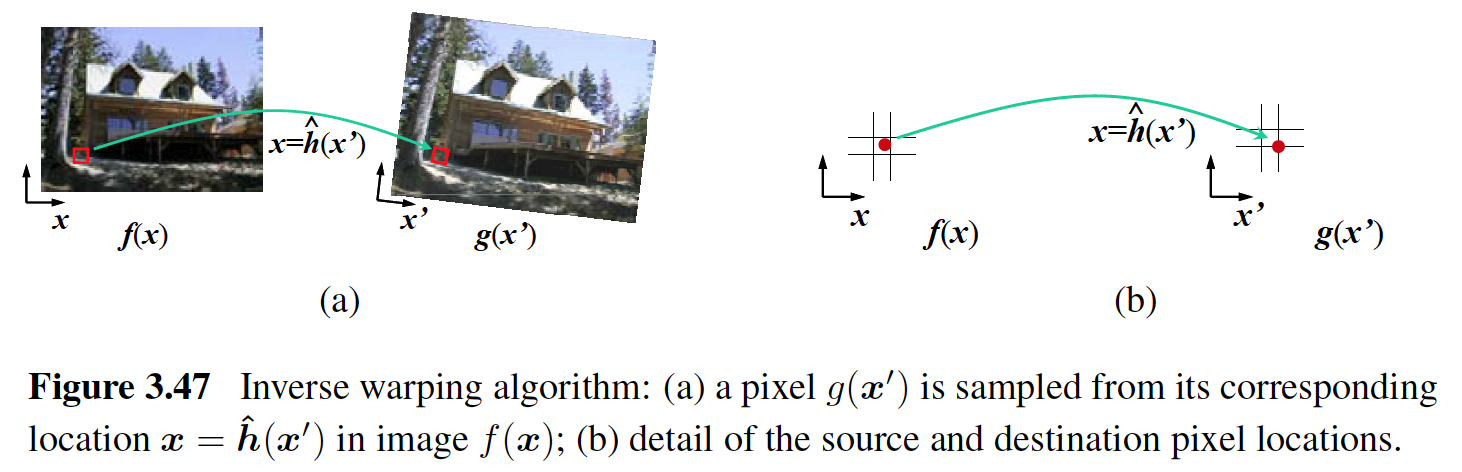

In [1]:
import numpy as np
from scipy import ndimage as scimage
import cv2
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/Colab\ Notebooks/data/

Mounted at /content/drive
'Armes 1.png'				    lizard.jpg
'Armes 2.png'				    MOT16-08-raw.webm
 blog_danforth_monica_mural_panorama.jpg    mountain_peak_1.png
 blog_monica_mural_brown_white.jpg	    mountain_peak_2.png
 blog_monica_mural_fish_tree_windows1.jpg   parking_lot_meva_1.png
 hawaii.png				    parking_lot_meva_2.png
 house_1.png				    parking_lot_meva_3.png
 house_2.png				    window_1.png
 house_facade.png			    window_2.png


width= 50 height= 70
width= 100 height= 70


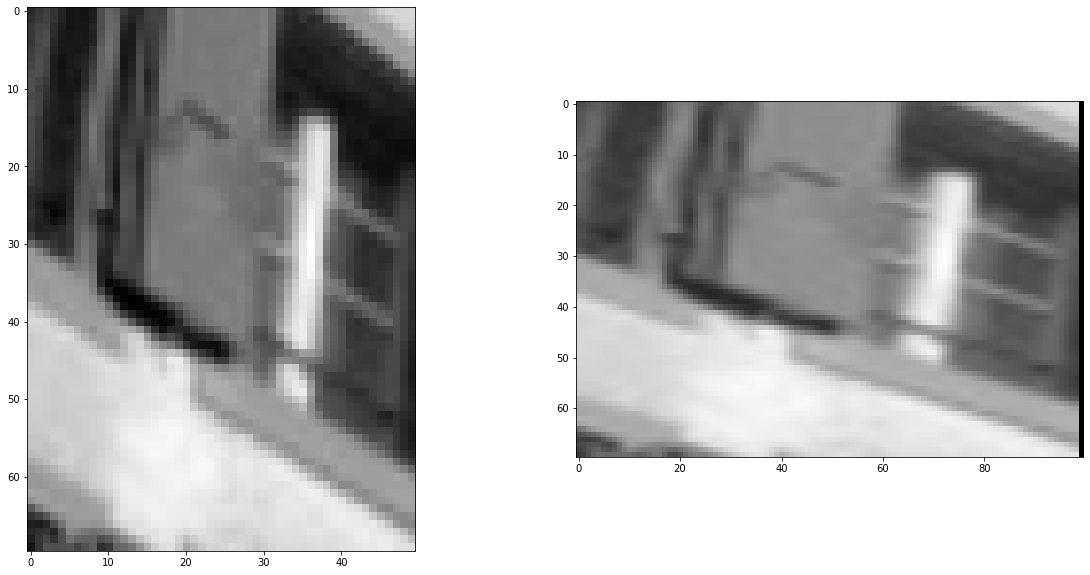

In [3]:
def inverse_warp (from_image_f, h, inv_h) :
    # h is a function that forward mapping function from f to g
    # inh_h is the function that mapps from g to f

    height_f, width_f = from_image_f.shape
    print('width=', width_f, 'height=', height_f)

    # First, map the corners of the from_image_f to decide on the size of to_image_g 
    # note the domain of indices for the final image is different from starting image
    # the forward map, h, is used to figure the boundary of the output domain.
    cx = []
    cy = []
    for fx in range(0, width_f+1, width_f) : # loops over the corner of from_image_f
        for fy in range(0, height_f+1, height_f) :
            x, y = h(fx, fy)
            cx.append(x)
            cy.append(y)
    max_x = np.max(cx).astype(int)
    max_y = np.max(cy).astype(int)
    min_x = np.min(cx).astype(int)
    min_y = np.min(cy).astype(int)
    width_g = (max_x - min_x)
    height_g = (max_y - min_y)
    print('width=', width_g, 'height=', height_g)
    to_image_g = np.zeros((height_g, width_g))

    # Second, find the pixel values in the output image using inverse map, h_inv
    for gx in range (min_x, max_x) :
        for gy in range (min_y, max_y) :
            fx, fy = inv_h(gx, gy)
            to_image_g[gy-min_y, gx-min_x] = scimage.map_coordinates(from_image_f, [[fy], [fx]], order=3)
 
    return(to_image_g)

def h (x, y) :
    #return (x, y)
    return (2*x+10, y+5)

def h_inv (x, y):
    #return (x, y)
    return ((x-10)/2, y-5)
    

# Load an color image in grayscale
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/data/Armes 1.png')
# Change color spaces. Can experiment with other spaces.
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = img.astype(np.float)  # need to change type from uint8 to float
img = img[30:100, 50:100]

out = inverse_warp (img, h, h_inv)

plt.figure(figsize = (20, 10))
plt.subplot(1,2,1)
plt.imshow(img, 'gray')
plt.subplot(1,2,2)
plt.imshow(out, 'gray')



In [4]:
def inverse_warp_2 (from_image_f, inv_h, output_shape) :
    # This function is similar in fuction to the warp function in scikit
    # inv_h is the function that mapps from g to f

    height_f, width_f = from_image_f.shape
    print('width=', width_f, 'height=', height_f)

    to_image_g = np.zeros(output_shape)

    # Second, find the pixel values in the output image using inverse map, h_inv
    for gx in range (output_shape[1]) :
        for gy in range (output_shape[0]) :
            fx, fy = inv_h(gx, gy)
            to_image_g[np.max(gy, 0), np.max(gx, 0)] = scimage.map_coordinates(from_image_f, [[fy], [fx]], order=3)
 
    return(to_image_g)


# Mathematical formulation of different types of transformations

See Section 2.1 of the textbook for this material

**Homogeneous coordinates of points:** 

A 2D points, $\mathbf{x} = \begin{bmatrix} x \\ y \end{bmatrix}$, is mapped to a 3D line through the origin given by 

\begin{equation}
\widetilde{\mathbf{x}} = w \begin{bmatrix}
        x \\ y\\ 1
    \end{bmatrix}
\end{equation}
    
We can see that we can transform a 2D representation to a 3-dimensional representation and vice-versa. We are referring to a theoretical 3D space here, not the 3D world we live in. We will study the fully 3D world model later; here, we explore the 2D world through 3D, theoretical representations.

We will see that expressing the points makes the representation of the transformations simpler, notation wise. Many transformations can be expressed as matrix multiplication, making it easier to represent a chain of transformations as simple matrix multiplications.

**Homogeneous coordinates of 2D lines:**

Equation of a 2D line can be written as $a x + b y + c = 0$ or as 

\begin{equation}
\begin{bmatrix}
        a & b & c
    \end{bmatrix}\begin{bmatrix}
        x \\ y \\ 1 
    \end{bmatrix} = 0 
\end{equation}
    
or as 

\begin{equation}
\widetilde{\mathbf{n}}^T \widetilde{\mathbf{x}} = 0,
\end{equation},

where $\widetilde{\mathbf{n}}$ is the homogeneous representation of a line. Note that the homogeneous representation of a line is the same as a point. Scaled version of the homogeneous representation, $w \widetilde{\mathbf{n}}$ represents the same line, as $w a x + w b y + w c = w (a x + b y + c) = 0$

**Intersection of two 2D lines**

In terms of homogeneous coordinates, the intersection of two lines is given by the **cross-product** of the line representations.

\begin{equation}
\widetilde{\mathbf{x}} = \widetilde{\mathbf{n_1}} \times \widetilde{\mathbf{n_2}}
\end{equation}

**Line joining two 2D points**

The line joining two points is given by the **cross-product** of the two-point representations.

\begin{equation}
\widetilde{\mathbf{n}} = \widetilde{\mathbf{x_1}} \times \widetilde{\mathbf{x_2}}
\end{equation}


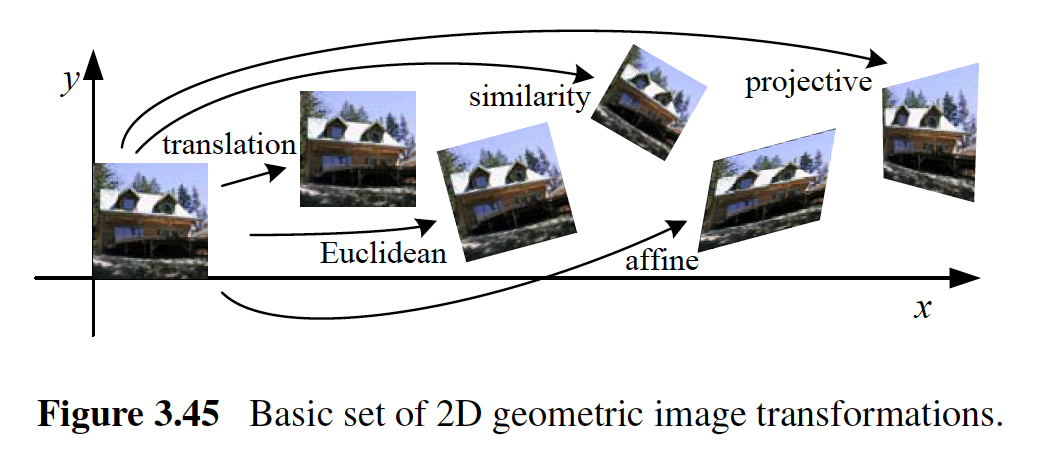

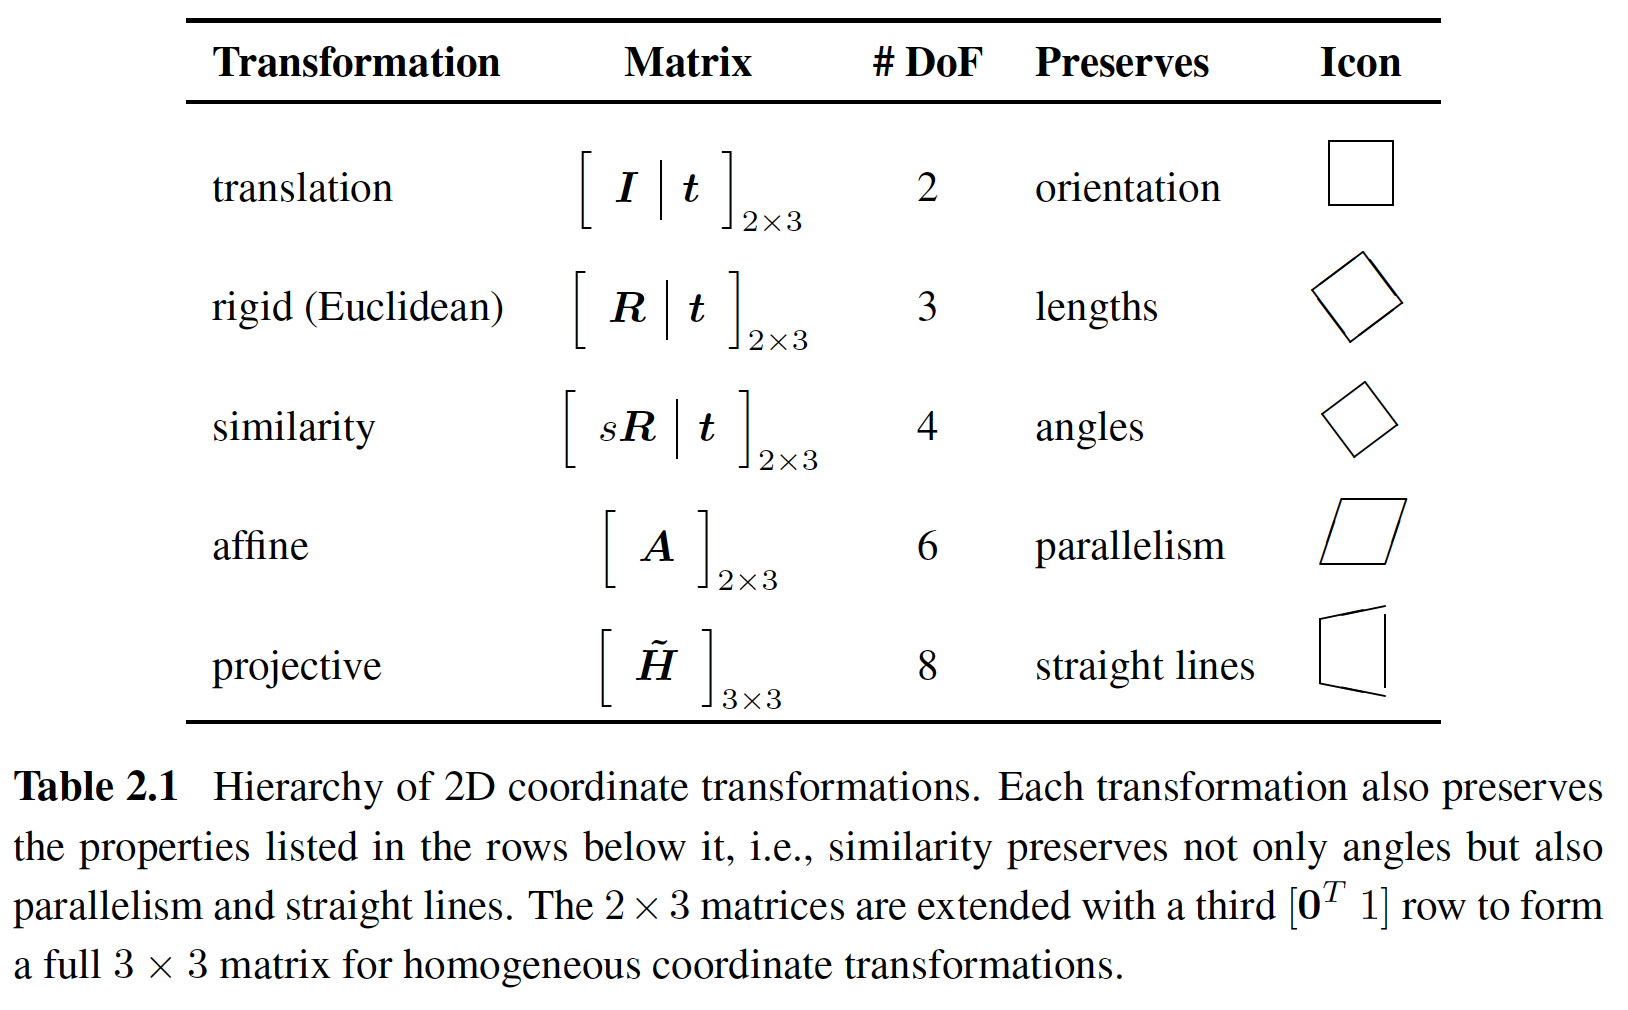

# 1. Translation 

Just translation preserves orientation, angles, and length
 
\begin{eqnarray}
        \mathbf{x}' & = & \mathbf{x} +\mathbf{t} \\
        \begin{bmatrix}
            x' \\ y' 
        \end{bmatrix} & = & \begin{bmatrix}
            x \\ y 
        \end{bmatrix} + \begin{bmatrix}
            t_x \\ t_y 
        \end{bmatrix} 
\end{eqnarray}

We can express the same in homogeneous coordinates as:
    
\begin{eqnarray}
        \begin{bmatrix}
            x' \\ y' \\ 1
        \end{bmatrix} & = & 
         \begin{bmatrix}
            1 & 0 & t_x \\
            0 & 1 & t_y \\
            0 & 0 & 1
        \end{bmatrix} 
        \begin{bmatrix}
            x \\ y \\ 1
        \end{bmatrix} \\
        \widetilde{\mathbf{x}'} & = & 
        \begin{bmatrix}
            \mathbf{I}^{2 \times 2} & \mathbf{t}^{2 \times 1} \\
            \mathbf{0}^{1 \times 2} & 1
        \end{bmatrix}
        \widetilde{\mathbf{x}}
\end{eqnarray}
    

# 2. Rotation and translation:

A rotation and translation of an image patch preserves angles and length
    
    
\begin{eqnarray}
    \mathbf{x}' & = & \mathbf{R}^{2 \times 2}\mathbf{x} +\mathbf{t} \\
    \begin{bmatrix}
        x' \\ y' 
    \end{bmatrix} & = & 
    \begin{bmatrix}
        \cos(\theta) & - \sin (\theta) \\
        \sin (\theta) & \cos (\theta)
    \end{bmatrix}
    \begin{bmatrix}
        x \\ y 
    \end{bmatrix} + \begin{bmatrix}
        t_x \\ t_y 
    \end{bmatrix} 
\end{eqnarray}

We can express the same in homogeneous coordinates as:
    
\begin{eqnarray}
    \begin{bmatrix}
        x' \\ y' \\ 1
    \end{bmatrix} & = & 
        \begin{bmatrix}
        \cos(\theta) & - \sin (\theta)& t_x \\
        \sin (\theta) & \cos (\theta) & t_y \\
        0 & 0 & 1
    \end{bmatrix} 
    \begin{bmatrix}
        x \\ y \\ 1
    \end{bmatrix} \\
    \widetilde{\mathbf{x}'} & = & 
    \begin{bmatrix}
        \mathbf{R}^{2 \times 2} & \mathbf{t}^{2 \times 1} \\
        \mathbf{0}^{1 \times 2} & 1
    \end{bmatrix}
    \widetilde{\mathbf{x}}
\end{eqnarray}
    
The rotation matrix is not any $2 \times 2$ matrix. It has certain properties it has to satisfy: $\mathbf{R}\mathbf{R}^T = \mathbf{R}^T\mathbf{R} = \mathbf{I}$ and $\det (\mathbf{R}) = 1$. The columns and rows are orthogonal to each other and their individual magnitude is one. In other words, the matrix is an **orthonormal** matrix.

width= 50 height= 70
width= 81 height= 85


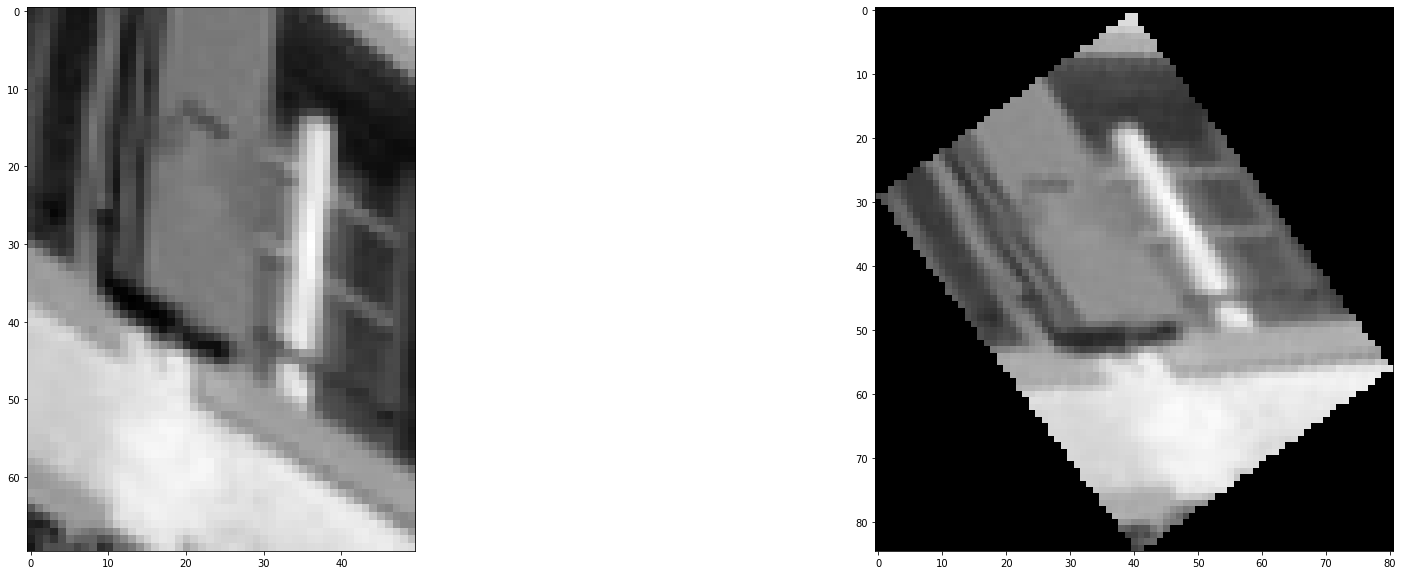

In [5]:
theta = -36*np.pi/180
t = np.array([0,0])

def h (x, y) :
    global theta, t
    R = np.array([[np.cos(theta), - np.sin(theta), t[0]],
                 [np.sin(theta),   np.cos(theta), t[1]],
                 [0            , 0              ,  1 ]]) 
    
    out = R @ np.array([[x],[y],[1]])
    return(out[0]/out[2], out[1]/out[2])

def h_inv (x, y):
    global theta, t
    R_inv = np.array([[np.cos(theta),  np.sin(theta), -t[0]],
                 [-np.sin(theta),   np.cos(theta), -t[1]],
                 [0            , 0              ,  1 ]]) 
    
    out = R_inv @ np.array([[x],[y],[1]]) 
    return(out[0]/out[2], out[1]/out[2])

    
out = inverse_warp (img, h, h_inv)

plt.figure(figsize = (30, 10))
plt.subplot(1,2,1)
plt.imshow(img, 'gray')
plt.subplot(1,2,2)
plt.imshow(out, 'gray')

# 3. Similarity Transformation 

If we allow for scaling, rotation, and translation only angles will be preserved.
    
\begin{eqnarray}
    \mathbf{x}' & = & s \mathbf{R}\mathbf{x} +\mathbf{t} \\
    \begin{bmatrix}
        x' \\ y' 
    \end{bmatrix} & = & 
    \begin{bmatrix}
        s \cos(\theta) & - s \sin (\theta) \\
        s \sin (\theta) & s \cos (\theta)
    \end{bmatrix}
    \begin{bmatrix}
        x \\ y 
    \end{bmatrix} + \begin{bmatrix}
        t_x \\ t_y 
    \end{bmatrix} 
\end{eqnarray}

We can express the same in homogeneous coordinates as:
    
\begin{eqnarray}
    \begin{bmatrix}
        x' \\ y' \\ 1
    \end{bmatrix} & = & 
        \begin{bmatrix}
        s \cos(\theta) & - s \sin (\theta)& t_x \\
        s \sin (\theta) & s \cos (\theta) & t_y \\
        0 & 0 & 1
    \end{bmatrix} 
    \begin{bmatrix}
        x \\ y \\ 1
    \end{bmatrix} \\
    \widetilde{\mathbf{x}'} & = & 
    \begin{bmatrix}
        \begin{bmatrix}
            a & -b \\
            b & a
        \end{bmatrix} & \mathbf{t}^{2 \times 1} \\
        \mathbf{0}^{1 \times 2} & 1
    \end{bmatrix}
    \widetilde{\mathbf{x}}
\end{eqnarray}
    
Note that unlike for a rotation matrix: $a^2 + b^2 \neq 1$.

width= 50 height= 70
width= 40 height= 42


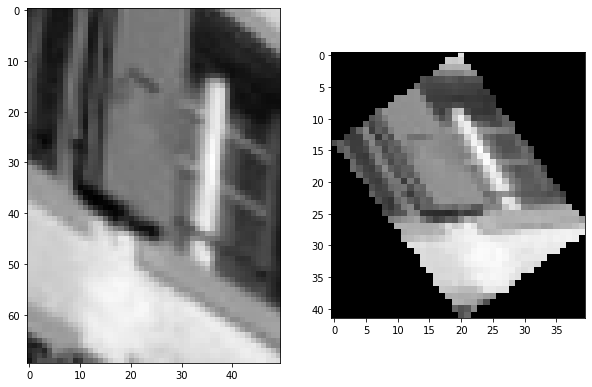

In [6]:
theta = -36*np.pi/180
t = np.array([0,0])
s = 0.5

def h (x, y) :
    global theta, t
    R = np.array([[s*np.cos(theta), - s*np.sin(theta), t[0]],
                 [s*np.sin(theta),   s*np.cos(theta), t[1]],
                 [0            , 0              ,  1 ]]) 
    
    out = R @ np.array([[x],[y],[1]])
    return(out[0]/out[2], out[1]/out[2])

def h_inv (x, y):
    global theta, t
    R_inv = np.array([[np.cos(theta)/s,  np.sin(theta)/s, -t[0]],
                      [-np.sin(theta)/s,   np.cos(theta)/s, -t[1]],
                       [0            , 0              ,  1 ]]) 
    
    out = R_inv @ np.array([[x],[y],[1]])   
    return(out[0]/out[2], out[1]/out[2])

    
out = inverse_warp (img, h, h_inv)

plt.figure(figsize = (10,40))
plt.subplot(1,2,1)
plt.imshow(img, 'gray')
plt.subplot(1,2,2)
plt.imshow(out, 'gray')

# 4. Affine

An affine transformation preserves only parallelism and changes orientation, angles, and lengths.
    
\begin{eqnarray}
    \begin{bmatrix}
        x' \\ y' \\ 1
    \end{bmatrix} & = & 
        \begin{bmatrix}
        a_{00} & a_{01} & t_x \\
        a_{10} & a_{11} & t_y \\
        0 & 0 & 1
    \end{bmatrix} 
    \begin{bmatrix}
        x \\ y \\ 1
    \end{bmatrix} 
\end{eqnarray} 

Note that the "rotation" matrix is allowed to be any possible $2 \times 2$ matrix.

width= 50 height= 70
width= 68 height= 59


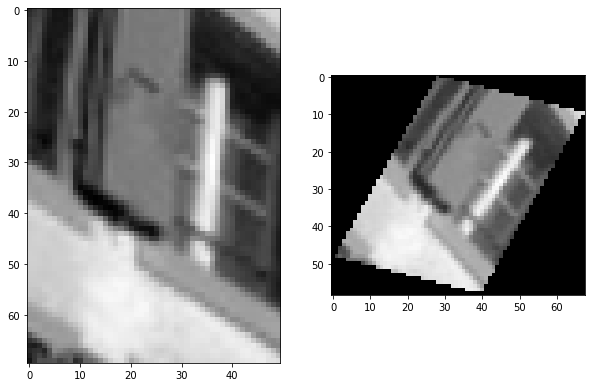

In [7]:
a = np.array([[0.8, 0], [0, 0.7]])
a = np.array([[0.8, 0.1], [0.1, 0.7]])
a = np.array([[0.8, -0.1], [0.1, 0.7]])
a = np.array([[0.8, 0.1], [-0.2, 0.7]])
a = np.array([[0.8, -0.4], [0.2, 0.7]])
t = np.array([0,0])


def h (x, y) :
    global a, t
    R = np.array([[a[0,0], a[0,1], t[0]],
                  [a[1,0],  a[1,1], t[1]],
                  [0            , 0              ,  1 ]]) 
    
    out = R @ np.array([[x],[y],[1]])
    return(out[0]/out[2], out[1]/out[2])

def h_inv (x, y):
    global theta, t
    b = np.linalg.inv(a)
    R_inv = np.array([[b[0,0],  b[0,1], -t[0]],
                      [b[1,0],  b[1,1], -t[1]],
                       [0    ,  0     ,  1 ]]) 
    
    out = R_inv @ np.array([[x],[y],[1]])   
    return(out[0]/out[2], out[1]/out[2])

    
out = inverse_warp (img, h, h_inv)

plt.figure(figsize = (10,40))
plt.subplot(1,2,1)
plt.imshow(img, 'gray')
plt.subplot(1,2,2)
plt.imshow(out, 'gray')

# Worksheet

Prove that affine transformation preserves parallel lines.


# 5. Stretch and squash

These transformations are restricted forms of affine transformation.
    
\begin{eqnarray}
    \begin{bmatrix}
        x' \\ y' \\ 1
    \end{bmatrix} & = & 
        \begin{bmatrix}
        a_{00} & 0 & t_x \\
        0 & a_{11} & t_y \\
        0 & 0 & 1
    \end{bmatrix}  
    \begin{bmatrix}
        x \\ y \\ 1
    \end{bmatrix}  
\end{eqnarray} 

width= 50 height= 70
width= 50 height= 42


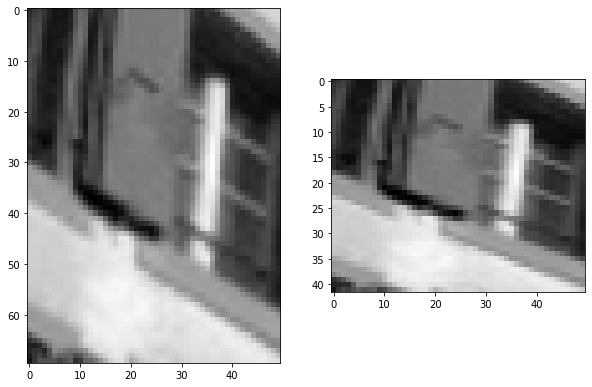

In [8]:
a = np.array([[1.0, 0], [0, 0.6]])


def h (x, y) :
    global a, t
    R = np.array([[a[0,0], a[0,1], t[0]],
                  [a[1,0],  a[1,1], t[1]],
                  [0            , 0              ,  1 ]]) 
    
    out = R @ np.array([[x],[y],[1]])
    return(out[0]/out[2], out[1]/out[2])

def h_inv (x, y):
    global theta, t
    b = np.linalg.inv(a)
    R_inv = np.array([[b[0,0],  b[0,1], -t[0]],
                      [b[1,0],  b[1,1], -t[1]],
                       [0    ,  0     ,  1 ]]) 
    
    out = R_inv @ np.array([[x],[y],[1]])   
    return(out[0]/out[2], out[1]/out[2])

    
out = inverse_warp (img, h, h_inv)

plt.figure(figsize = (10,40))
plt.subplot(1,2,1)
plt.imshow(img, 'gray')
plt.subplot(1,2,2)
plt.imshow(out, 'gray')

# 6. Projective

This transformation, which is very commonly used in computer vision, preserves only straight lines, i,e. straight lines gets matched to straight lines, but other properties are not preserved including parallelism. This is the geometric model relating two perspective views of a plane. We will study this later.
    
\begin{eqnarray}
    \begin{bmatrix}
        a \\ b \\ c
    \end{bmatrix} & = & 
        \begin{bmatrix}
        h_{00} & h_{01} & h_{02}\\
        h_{10} & h_{11} & h_{12} \\
        h_{20} & h_{21} & h_{22}
    \end{bmatrix} 
    \begin{bmatrix}
        x \\ y \\ 1
    \end{bmatrix}  \\
    \widetilde{\mathbf{x}'} & = & \widetilde{\mathbf{H}} \widetilde{\mathbf{x}} \\
    \mathbf{x} & = & \begin{bmatrix}
        a/c \\ b/c
    \end{bmatrix}
\end{eqnarray} 
    
Lines are also transformed into lines by homography. Similar relationship can be derived for the other transformations.
    
\begin{eqnarray}
    \widetilde{\mathbf{x}'} & = & \widetilde{\mathbf{H}} \widetilde{\mathbf{x}}   \\
    \widetilde{\mathbf{x}} & = & \widetilde{\mathbf{H}}^{-1} \widetilde{\mathbf{x}'}  \\
    \widetilde{\mathbf{n}}^{T} \widetilde{\mathbf{x}} & = & 0 \\
    \widetilde{\mathbf{n}}^{T} \widetilde{\mathbf{H}}^{-1} \widetilde{\mathbf{x}'} & = & 0 \\
    (\widetilde{\mathbf{n}}^{T} \widetilde{\mathbf{H}}^{-1}) \widetilde{\mathbf{x}'} & = & 0 \\
    (\widetilde{\mathbf{H}}^{-T}\widetilde{\mathbf{n}} )^{T} \widetilde{\mathbf{x}'} & = & 0 \\
    \widetilde{\mathbf{n}'} & = & (\widetilde{\mathbf{H}}^{-T}\widetilde{\mathbf{n}} )
\end{eqnarray}

width= 50 height= 70
width= 71 height= 46


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


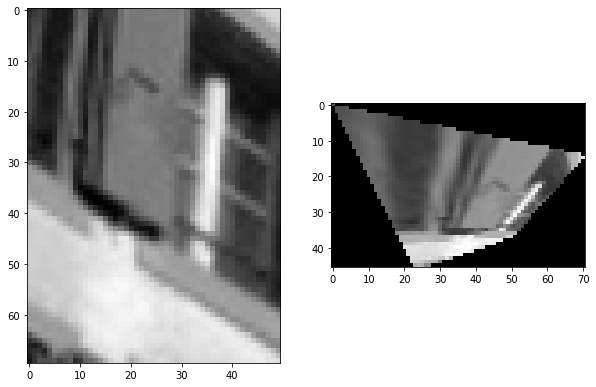

In [9]:
H = np.array([[1.0, 0, 0], [0, 0.6, 0], [0, 0, 0.9]])
H = np.array([[1.0, 0.3, 0], [0.2, 0.6, 0], [0, 0, 0.9]])
H = np.array([[1.0, 0.3, 0], [0.2, 0.6, 0], [0.01, 0.01, 0.2]])


def h (x, y) :
    global H
    out = H @ np.array([[x],[y],[1]])
    return(out[0]/out[2], out[1]/out[2])

def h_inv (x, y):
    global H
    H_inv = np.linalg.inv(H)
    out = H_inv @ np.array([[x],[y],[1]])   
    return(out[0]/out[2], out[1]/out[2])

    
out = inverse_warp (img, h, h_inv)

plt.figure(figsize = (10,40))
plt.subplot(1,2,1)
plt.imshow(img, 'gray')
plt.subplot(1,2,2)
plt.imshow(out, 'gray')

# Transformation Groups

A (mathematical) [group](https://www.mathsisfun.com/sets/groups-introduction.html) is a set (points in 2D in our case) together with an operation (one of the geometric transformations we have studied above) and exhibit the four properties: closure, associativity, identity and invertibility.

The geometric transformations that we have studied (with some restrictions on degenerate values) along with the set of 2D points form closed groups. In fact, they form a nested set of groups.  Which transformations exhibit this property?
    
1. Rigid transformations form a group as it is invertible. 

2. Not all affine and projective are invertible. If we restrict these transformations to be invertible then they form groups. 

3. They all have the other three properties. 

# Notation Conventions

We will use the following notation to generically represent these transformations.

\begin{equation}
    \mathbf{f} (\widetilde{\mathbf{x_i}}; \mathbf{p})
\end{equation}

where $\mathbf{p}$ is the set of parameters to be estimated. Note that the range of this function is vector valued and the domain of the function is also vector-valued.
    
For numerical convenience of choosing initialization, we usually reparameterize the transformations so that when the parameters, $\mathbf{p}$, are all zero, i.e., the point does not move. To achieve this we add a 1 to the first two diagonal values of the transformation matrix. See Table 6.1

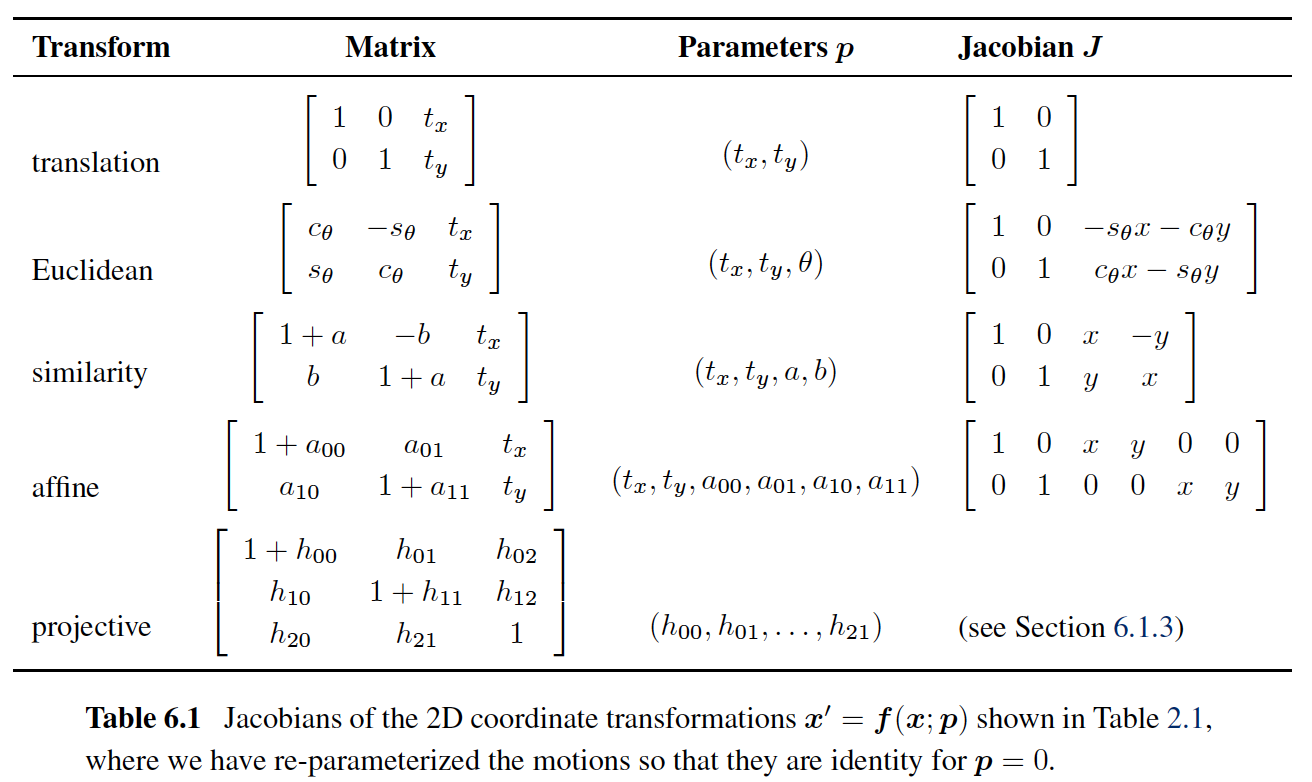

# What is Jacobian?

* The quantity Jacobian is named are [Carl Gustav Jacob Jacobi](https://en.wikipedia.org/wiki/Carl_Gustav_Jacob_Jacobi).

* A Jacobian, denoted by $\mathbf{J}$, is the derivative of a vector-valued function, such as the transformation functions that we have $\mathbf{f} (\widetilde{\mathbf{x_i}}; \mathbf{p})$, with respect to the parameters, $\mathbf{p}$. It is a matrix of first derivatives that will be used in the estimation process. 

* The Jacobian matrix in our case *could* be function of both ${\mathbf{x_i}}$ and $\mathbf{p}$, which can be explicitly denoted using $J (\widetilde{\mathbf{x_i}}; \mathbf{p})$. If the Jacobian is a function of the parameters, $\mathbf{p}$, then we have a **non-linear estimation problem** at hand, and we will need an interactive estimation process. If the Jacobian is not a function of the parameters, $\mathbf{p}$, then we have a **linear estimation problem** and can have the solution in closed form, in one-shot. Note that this concept of linearity is different from the transformation itself is linear or non-linear. The function linearity and estimation linearity are two different concepts.

* This Jacobian will be an $d \times n$ matrix, where the number of dimensions is d and the number of parameters is $n$. The $ij$-th entry of this matrix  $J_{ij} = \frac{\partial f_i}{\partial p_j}$.

\begin{equation}
\mathbf{J} = 
\begin{bmatrix}
    \dfrac{\partial \mathbf{f}}{\partial p_1} & \cdots & \dfrac{\partial \mathbf{f}}{\partial p_{n}} 
    \end{bmatrix}
= \begin{bmatrix}
    \nabla^T f_1 \\  
    \vdots \\
    \nabla^T f_d   
    \end{bmatrix}
= \begin{bmatrix}
    \dfrac{\partial f_1}{\partial x_1} & \cdots & \dfrac{\partial f_1}{\partial x_n}\\
    \vdots & \ddots & \vdots\\
    \dfrac{\partial f_d}{\partial x_1} & \cdots & \dfrac{\partial f_d}{\partial x_n} \end{bmatrix}
\end{equation}
    

# Jacobian for Translation

\begin{eqnarray}
    \mathbf{f} (\widetilde{\mathbf{x_i}}; \mathbf{p}) = 
\begin{bmatrix}
    f_x \\ f_y \\ 1
\end{bmatrix}  & = & 
    \begin{bmatrix}
        1 & 0 & t_x \\
        0 & 1 & t_y \\
        0  & 0 & 1
    \end{bmatrix} 
    \begin{bmatrix}
        x_i \\ y_i \\ 1
    \end{bmatrix} 
\end{eqnarray}
   
The parameter vector is two dimensional and is given by  
$\mathbf{p} = 
\begin{bmatrix}
    t_x \\ t_y 
\end{bmatrix}$. 

The Jacobian, corresponding to the $i$-the point, $\mathbf{J(x_i; p)}$ is given by
   
\begin{eqnarray}
    \mathbf{J(x_i; p)} & = & 
    \frac{\partial}{\partial \mathbf{p}} \mathbf{f}(\widetilde{\mathbf{x_i}}; \mathbf{p})\\
    & = & 
    \begin{bmatrix}
        \frac{\partial}{\partial t_x} f_x & 
        \frac{\partial}{\partial t_y} f_x \\
        \frac{\partial}{\partial t_x} f_y & 
        \frac{\partial}{\partial t_y} f_y \\
    \end{bmatrix} \\
    & = & 
    \begin{bmatrix}
        1 & 0  \\
        0 & 1 
    \end{bmatrix}
\end{eqnarray} 

# Jacobian for Euclidean (rigid motion) 2D rotation + translation

2D rigid motion is characterized by a 2D rotation matrix and a translation vector.

\begin{eqnarray}
    \mathbf{f} (\widetilde{\mathbf{x_i}}; \mathbf{p}) = 
\begin{bmatrix}
    f_x \\ f_y \\ 1
\end{bmatrix} 
    & = & 
    \begin{bmatrix}
        \cos \theta & - \sin \theta & t_x \\
        \sin \theta & \cos \theta & t_y \\
        0  & 0 & 1
    \end{bmatrix} 
    \begin{bmatrix}
        x_i \\ y_i \\ 1
    \end{bmatrix}
\end{eqnarray}
   
The parameter vector is three dimensional and is given by  $\mathbf{p} = 
\begin{bmatrix}
    t_x \\ t_y \\ \theta
\end{bmatrix}$. 

The Jacobian, corresponding to the $i$-the point, $\mathbf{J(x_i; p)}$ is given by
   
\begin{eqnarray}
    \mathbf{J(x_i; p)} & = & \frac{\partial}{\partial \mathbf{p}} f(\widetilde{\mathbf{x_i}}; \mathbf{p})\\
    & = & 
    \begin{bmatrix}
        \frac{\partial}{\partial t_x} f_x & 
        \frac{\partial}{\partial t_y} f_x & 
        \frac{\partial}{\partial \theta} f_x \\
        \frac{\partial}{\partial t_x} f_y & 
        \frac{\partial}{\partial t_y} f_y & 
        \frac{\partial}{\partial \theta} f_y \\
    \end{bmatrix}  \\
    & = & 
    \begin{bmatrix}
        1 & 0 & (-\sin(\theta) x_i - \cos(\theta) y_i) \\
        0 & 1 & (\cos(\theta) x_i - \sin(\theta) y_i)
    \end{bmatrix}
\end{eqnarray} 
    
Note that the Jacobian is a function of the parameter, $\theta$ and the derivative of the residual will not yield a linear equation from which we can derive a closed form solution. Unlike for the translation case, there is no linear inversion process to estimate the parameters for rigid motion. 

# Jacobian for Similarity Transformation Estimation 

The similarity transformation is comprised of a compress and strech plus translation.

\begin{eqnarray}
    \mathbf{f} (\widetilde{\mathbf{x_i}}; \mathbf{p}) = 
\begin{bmatrix}
    f_x \\ f_y \\ 1
\end{bmatrix} 
    & = & 
    \begin{bmatrix}
        1+a & - b & t_x \\
        b & 1+a & t_y \\
        0  & 0 & 1
    \end{bmatrix} 
    \begin{bmatrix}
        x_i \\ y_i \\ 1
    \end{bmatrix}
\end{eqnarray}

The parameter vector is four dimensional 
$\mathbf{p} = 
\begin{bmatrix}
    t_x \\ t_y \\ a \\ b
\end{bmatrix}$. 

Note that we have parameterized the transformation in such a way that $\mathbf{f} (\widetilde{\mathbf{x_i}}; \mathbf{p}=0) = \widetilde{\mathbf{x_i}}$ or $\mathbf{p}=0$ results in an identity transformation.



The Jacobian, corresponding to the $i$-the point, $\mathbf{J(x_i)}$ is given by
\begin{equation}
    \mathbf{J(\mathbf{x_i})} = \begin{bmatrix}
        \frac{\partial}{\partial t_x} f_x & 
        \frac{\partial}{\partial t_y} f_x & 
        \frac{\partial}{\partial a} f_x & 
        \frac{\partial}{\partial b} f_x \\
        \frac{\partial}{\partial t_x} f_y & 
        \frac{\partial}{\partial t_y} f_y & 
        \frac{\partial}{\partial a} f_y & 
        \frac{\partial}{\partial b} f_y \\
    \end{bmatrix}  = \begin{bmatrix}
        1 & 0 & x_i & y_i \\
        0 & 1 & y_i & x_i
    \end{bmatrix}
\end{equation}

Note that this Jacobian is not a function of the function parameters, so we can have a linear estimate for it.

# Jacobian for Affine Transformation

The affine transformation is further generalized version of the similarity transform.

\begin{eqnarray}
    \mathbf{f} (\widetilde{\mathbf{x_i}}; \mathbf{p}) = 
\begin{bmatrix}
    f_x \\ f_y \\ 1
\end{bmatrix} 
    & = & 
    \begin{bmatrix}
        1+a_{00} & a_{01} & t_x \\
        a_{10} & 1+a_{11} & t_y \\
        0  & 0 & 1
    \end{bmatrix} 
    \begin{bmatrix}
        x_i \\ y_i \\ 1
    \end{bmatrix}
\end{eqnarray}

The parameter vector is four dimensional 
$\mathbf{p} = 
\begin{bmatrix}
    a_{00} \\ a_{01} \\ t_x \\ a_{10} \\ a_{11} \\ t_y
\end{bmatrix}$. 

Like earlier, we have parameterized the transformation in such a way that $\mathbf{f} (\widetilde{\mathbf{x_i}}; \mathbf{p}=0) = \widetilde{\mathbf{x_i}}$ or $\mathbf{p}=0$ results in an identity transformation.



The Jacobian, corresponding to the $i$-the point, $\mathbf{J(x_i)}$ is given by


\begin{eqnarray}
    \frac{\partial}{\partial \mathbf{p}} f (\widetilde{\mathbf{x_i}}; \mathbf{p}) & = & 
\begin{bmatrix}
        \frac{\partial}{\partial a_{00}} f_x & 
        \frac{\partial}{\partial a_{01}} f_x & 
        \frac{\partial}{\partial t_x} f_x & 
        \frac{\partial}{\partial a_{10}} f_x &
        \frac{\partial}{\partial a_{11}} f_x &
        \frac{\partial}{\partial t_y} f_x \\
        \frac{\partial}{\partial a_{00}} f_y & 
        \frac{\partial}{\partial a_{01}} f_y & 
        \frac{\partial}{\partial t_x} f_y & 
        \frac{\partial}{\partial a_{10}} f_y &
        \frac{\partial}{\partial a_{11}} f_y &
        \frac{\partial}{\partial t_y} f_y
        \end{bmatrix}  \\
    & = & 
\begin{bmatrix}
    x_i & y_i & 0 & 0     & 1 & 0\\
    0   & 0   & x_i & y_i & 0 & 1
\end{bmatrix}
\end{eqnarray}

Note that like the similarity transform the components of the Jacobian do not involve the parameters being estimated. Because of this property, we would be able to solve this particular problem in a non-iterative fashion, i.e. there is a closed form expression of the solution.

# Jacobian for 2D Perspective Transform
    
Recall that the transformation can be represented as 
    
\begin{eqnarray}
    \begin{bmatrix}
        a \\ b \\ c
    \end{bmatrix} & = & 
    \begin{bmatrix}
        h_{00} & h_{01} & h_{02}\\
        h_{10} & h_{11} & h_{12} \\
        h_{20} & h_{21} & h_{22}
    \end{bmatrix} 
    \begin{bmatrix}
        x \\ y \\ 1
    \end{bmatrix}  \\
    \widetilde{\mathbf{x}'} & = & \widetilde{\mathbf{H}} \widetilde{\mathbf{x}} \\
    \mathbf{x}' = 
    \begin{bmatrix} 
    x' \\ y' 
    \end{bmatrix}
    & = & 
    \begin{bmatrix}
        a/c \\ b/c
    \end{bmatrix}
\end{eqnarray} 
    
Note that scaling of the transformation matrix, $\widetilde{\mathbf{H}} $, results in the same point $\mathbf{x}'$. This means that the transformation matrix can be known only up to a scale. Another aspect of this is that there are infinite number of solutions. To constrain the solution space, we can one of the parameters of the transformation matrix to a constant value. Typically, this is $h_{22}$, which is set to 1.  This, along with reparameterization of the transformation so that $\mathbf{p} = \mathbf{0}$ is the identity transformation, we arrive at the following effective representation of the transformation.

\begin{eqnarray}
    \begin{bmatrix}
        a \\ b \\ D
    \end{bmatrix} & = & 
    \begin{bmatrix}
        1+h_{00} & h_{01} & h_{02}\\
        h_{10} & 1+h_{11} & h_{12} \\
        h_{20} & h_{21} & 1
    \end{bmatrix} 
    \begin{bmatrix}
        x_i \\ y_i \\ 1
    \end{bmatrix}  \\
    \mathbf{\hat{x}}' = \begin{bmatrix} \hat{x}_i' \\ \hat{y}_i' \end{bmatrix}
    & = & 
    \begin{bmatrix}
        a/D \\ b/D
    \end{bmatrix}
\end{eqnarray} 
    
    
The parameter vector is eight dimensional and is given by  $\mathbf{p} = \begin{bmatrix}
    h_{00} & h_{01} & \cdots & h_{21}
\end{bmatrix}^T$. 

The Jacobian, corresponding to the $i$-the point, $\mathbf{J(x_i; p)}$ is given by

\begin{eqnarray}
    \mathbf{J(x_i; p)} & = & \frac{\partial}{\partial \mathbf{p}} f(\widetilde{\mathbf{x_i}}; \mathbf{p})\\
    & = & \begin{bmatrix}
            \frac{\partial}{\partial h_{00}} \hat{x}_i' & 
            \frac{\partial}{\partial h_{01}} \hat{x}_i' & \cdots & \frac{\partial}{\partial h_{21}} \hat{x}_i' \\
            \frac{\partial}{\partial h_{00}} \hat{y}_i' & 
            \frac{\partial}{\partial h_{01}} \hat{y}_i' & \cdots & \frac{\partial}{\partial h_{21}} \hat{y}_i' \\
    \end{bmatrix} 
\end{eqnarray} 

\begin{eqnarray}
\hat{x}_i' & = & \frac{(1+h_{00}) x_i + h_{01} y_i + h_{02}}{h_{20} x_i + h_{21} y_i + 1} \\
\hat{y}_i' & = & \frac{(1+h_{10}) x_i + h_{11} y_i + h_{12}}{h_{20} x_i + h_{21} y_i + 1} \\
\end{eqnarray}

Note $\frac{\partial \hat{x}_i'}{\partial h_{10}} = \frac{\partial \hat{x}_i'}{\partial h_{11}} = \frac{\partial \hat{x}_i'}{\partial h_{12}} = 0$, as $\hat{x}_i'$ does not depend on these parameters. Similarly, $\frac{\partial \hat{y}_i'}{\partial h_{00}} = \frac{\partial \hat{y}_i'}{\partial h_{01}} = \frac{\partial \hat{y}_i'}{\partial h_{02}} = 0$.

For ease of notation, let us use $D$ to represent the denominator,  $h_{20} x_i + h_{21} y_i + 1$. Then, $\frac{\partial \hat{x}_i'}{\partial h_{00}} = \frac{x_i}{D}$, $\frac{\partial \hat{x}_i'}{\partial h_{01}} = \frac{y_i}{D}$, and $\frac{\partial \hat{x}_i'}{\partial h_{02}} = \frac{1}{D}$.

And,
\begin{eqnarray}
     \frac{\partial \hat{x}_i'}{\partial h_{20}} & = & - \frac{x_i}{D^2} ( (1+h_{00}) x_i + h_{01} y_i + h_{02}) \\
     & = & - \frac{x_i}{D} \frac{(1+h_{00}) x_i + h_{01} y_i + h_{02}}{D} \\
     & = & - \frac{x_i \hat{x}_i'}{D}
\end{eqnarray}

\begin{eqnarray}
     \frac{\partial \hat{x}_i'}{\partial h_{21}} & = & - \frac{y_i}{D^2} ( (1+h_{00}) x_i + h_{01} y_i + h_{02}) \\
     & = & - \frac{y_i}{D} \frac{(1+h_{00}) x_i + h_{01} y_i + h_{02}}{D} \\
     & = & - \frac{y_i \hat{x}_i'}{D}
\end{eqnarray}

The Jacobian for projective transformation (homography) is given by 

\begin{equation}
    J(\mathbf{x_i}; \mathbf{p}) = \frac{1}{D}
\begin{bmatrix}
    x_i & y_i & 1 & 0 & 0 & 0 & - x_i \hat{x}_i' & - y_i \hat{x}_i'\\
    0 & 0 & 0 & x_i & y_i & 1  & - x_i \hat{y}_i'  & - y_i \hat{y}_i'
\end{bmatrix}\end{equation}

Note that the $(\hat{x}_i', \hat{y}_i')$ and the denominator $D = h_{20} x_i + h_{21} y_i + 1$, depend on the current parameter settings.

Also note that the Jacobian involves predicted feature locations based on the current model parameters, $(\hat{x}_i', \hat{y}_i')$,  instead of sensed feature locations in the next image, $({x}_i', {y}_i')$.
